# Problem 1:

Construct a CNN to classify the images in the MRI dataset. 

# Problem 2: Pretrained Networks

Using OpenCV, we can also capture images from the computers camera. Open CV is a powerful image processing library from C++ that servers as the benchmark in image processing across industries. To install the python bindings for open CV, open an anaconda prompt (or console on OSX) any use 

Windows:

    conda install -c menpo opencv
    
OSX/*nix:

    conda install --channel https://conda.anaconda.org/menpo opencv3

to install open CV. 

(480, 640, 3)


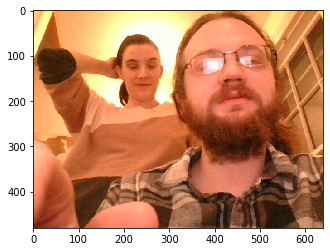

In [5]:
import cv2
video_capture = cv2.VideoCapture(0)
# Check success
if not video_capture.isOpened():
    raise Exception("Could not open video device")
# Read picture. ret === True on success
ret, frame = video_capture.read()
# Close device
video_capture.release()


from matplotlib import pyplot as plt
frameRGB = frame[:,:,::-1] # BGR => RGB
plt.imshow(frameRGB)

print(frame.shape)

Let's pull in our preprocessing functions for the Xception network:

In [6]:
import tensorflow as tf

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

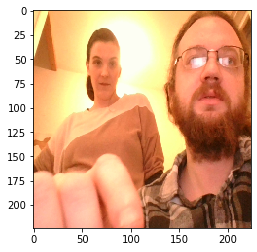

In [7]:
import cv2
video_capture = cv2.VideoCapture(0)
# Check success
if not video_capture.isOpened():
    raise Exception("Could not open video device")
# Read picture. ret === True on success
ret, frame = video_capture.read()
# Close device
video_capture.release()


from matplotlib import pyplot as plt
frameRGB = frame[:,:,::-1] # BGR => RGB
plt.imshow((preprocess(frameRGB,1)[0].numpy() + 1)/2)

Note: `xception.preprocess_input` scales and shifts the image to take pixel values between [-1,1]. For `plt.imshow` to properly display the color information you must add 1 and divide by 2.  

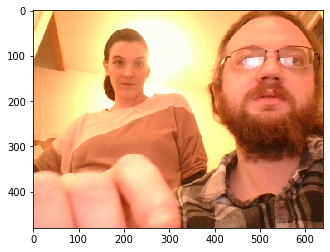

In [8]:
plt.imshow(frameRGB)

You can use the code above to capture 100 pictures of yourself, and split the pictures into labeled sets. For example, you could capture 100 smiling picture and 100 angry pictures. Or 100 pictures in each of 3 different hats. 

In [12]:
import numpy as np

N = 4 # Number of Pictures per Category
C = 3  # Number of categories, for example happy, angry, sad

a_shape = (C*N,) + frameRGB.shape # We want an array the shape of your cameras image, with C*N items. 

x_train = np.zeros(a_shape)
y_train = np.zeros([N*C]).astype('int64')

labels = ["Nate", "Rachel", "Both"]


print(x_train.shape)

(12, 480, 640, 3)


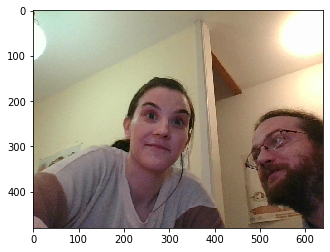

In [15]:

import time
import os
from IPython.display import display, clear_output


video_capture.release()  # Release hold of the camera in case its still active
video_capture = cv2.VideoCapture(0)

# Check success
if not video_capture.isOpened():
    raise Exception("Could not open video device")
# Read picture. ret === True on success

for j in range(C):
    for i in range(N):
        print("Category:", labels[j])
        
        print("Picture",i)
        os.system("printf '\a'") # or '\7'
        time.sleep(2)
        clear_output(wait=True)
        ret, frame = video_capture.read()
        if ret:
            frameRGB = frame[:,:,::-1]
            x_train[N*j+i,:,:,:] = frameRGB
            y_train[N*j+i] = j
            plt.imshow(frame[:,:,::-1])
            plt.show()

        else:
            print("Could not take picture")

        # Close device
video_capture.release()

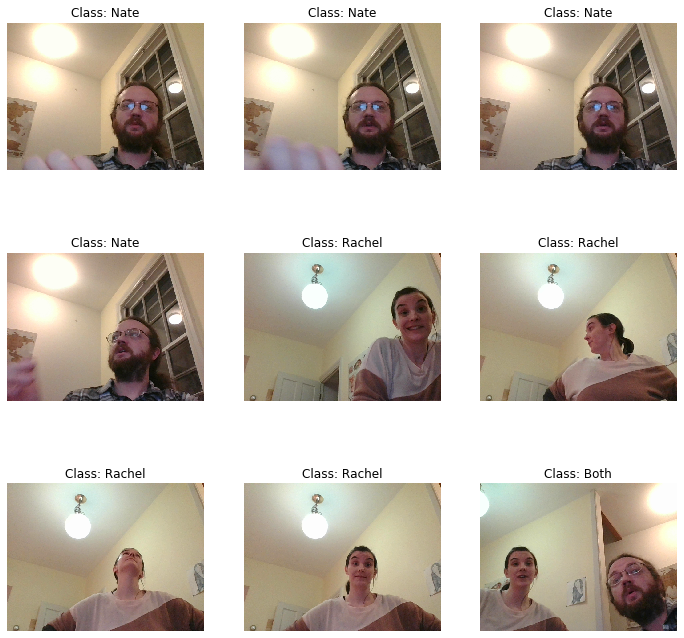

In [16]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i,:,:,:]/255)
    plt.title("Class: {}".format(labels[y_train[i]]))
    plt.axis("off")

We now want to train the network on this data. The Xception model expects a Tensorflow dataset object instead of a set of images and labels. This requires building a Tensorflow dataset. This is not hard once you have the syntax together. The simplest way to generate a dataset from data is using a `from_tensor_slices` call:

* `ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))` - Constructs a dataset with X data `x_train` and label data `y_train`. Data can be quarried using `ds.take`. 

In general, `tf.Dataset` objects enforce some data handling standards, and although they can be a bit of trouble to work with, they also contain useful functions for batching, preprocessing, and shuffling. 

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [17]:
ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ds

<TensorSliceDataset shapes: ((480, 640, 3), ()), types: (tf.float64, tf.int64)>

We now split our data into batches, shuffle it, and preprocess it:

In [18]:
batch_size = 1
ds = ds.shuffle(1)
ds = ds.map(preprocess).batch(batch_size).prefetch(1)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

Finally, we form the train-test split. We will take 2/3 of our data as train and 2/3 as validate. Since in this example we're using 12 images, this means we `take` 9 data points and `skip` the other 3:

In [19]:
ds.train=ds.take(9)
ds.validate=ds.skip(9) 

Now, we load the Xception model:

In [20]:
n_classes = len(labels)

base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

Freeze the internal layers

In [21]:
for layer in base_model.layers:
    layer.trainable = False

and train:

In [22]:
optimizer = tf.keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(ds.train, epochs=5, validation_data=ds.validate)

Epoch 1/5
9/9 [==============================] - 5s 583ms/step - loss: 7.4770 - accuracy: 0.5556 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
9/9 [==============================] - 2s 246ms/step - loss: 35.1518 - accuracy: 0.0000e+00 - val_loss: 23.5158 - val_accuracy: 0.0000e+00
Epoch 3/5
9/9 [==============================] - 2s 273ms/step - loss: 8.6308 - accuracy: 0.2222 - val_loss: 33.5465 - val_accuracy: 0.0000e+00
Epoch 4/5
9/9 [==============================] - 3s 292ms/step - loss: 4.8790 - accuracy: 0.2222 - val_loss: 26.0652 - val_accuracy: 0.0000e+00
Epoch 5/5
9/9 [==============================] - 2s 253ms/step - loss: 1.3618 - accuracy: 0.7778 - val_loss: 19.4364 - val_accuracy: 0.0000e+00


#### Question:

Modify the code above to classify something of your choosing. For example, take pictures of yourself and a friend, in one hat or another, your dog vs your hamster. Your initial dataset should be around 100 images per class. Can you construct an accurate classifier?

#### Question (Alternative):

Kaggle hosts a dataset of movies posters that can be classified by genre. 

https://www.kaggle.com/neha1703/movie-genre-from-its-poster

Repeat the pipeline above to classify the movies posters. This task will involve several steps:

1. Download the data. 
2. Load the labels file, and get the number of unique labels.  
3. Since movies have multiple labels, you should construct a label vector that has a 1 for every genre the movie represents and a 0 otherwise. 
4. Load the images and store them in tf.Dataset. 
5. Construct a new Xception extension to classify the images. You will need to change "sparse_categorical_crossentropy" which takes integer values to keras.losses.CategoricalCrossentropy(from_logits=True). This will instead compute individual probabilities for each label.  